# Imports

In [5]:
from IPython.display import clear_output, Image
from torchvision.models import ResNet152_Weights
from torchvision.io import read_image, ImageReadMode

import cv2
import numpy as np
import os
import pandas as pd
import shutil
import torch

In [7]:
!pip install roboflow --quiet
from roboflow import Roboflow

In [8]:
!pip install ultralytics==8.0.57
clear_output()

from ultralytics import YOLO

import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 15.6 GB RAM, 4526.9/8062.4 GB disk)


In [6]:
HOME = os.getcwd()
print(HOME)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

/kaggle/working
cuda:0


# Downloading the Dataset

Download the dataset from Roboflow:

In [9]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="ZsZB2FnCmcNaslwIlejv")
project = rf.workspace("mydatasets-bqwxe").project("kaggle-kontur")
dataset = project.version(8).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.57, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Kaggle-Kontur-8 in yolov8:: 100%|██████████| 1885/1885 [00:00<00:00, 2449.00it/s]


# YOLO Training

Run the training process:

In [ ]:
!yolo task=detect mode=train model=/kaggle/working/runs/detect/train2/weights/last.pt data={dataset.location}/data.yaml epochs=90 imgsz=896 plots=True save_period=10

Plot losses and metrics:

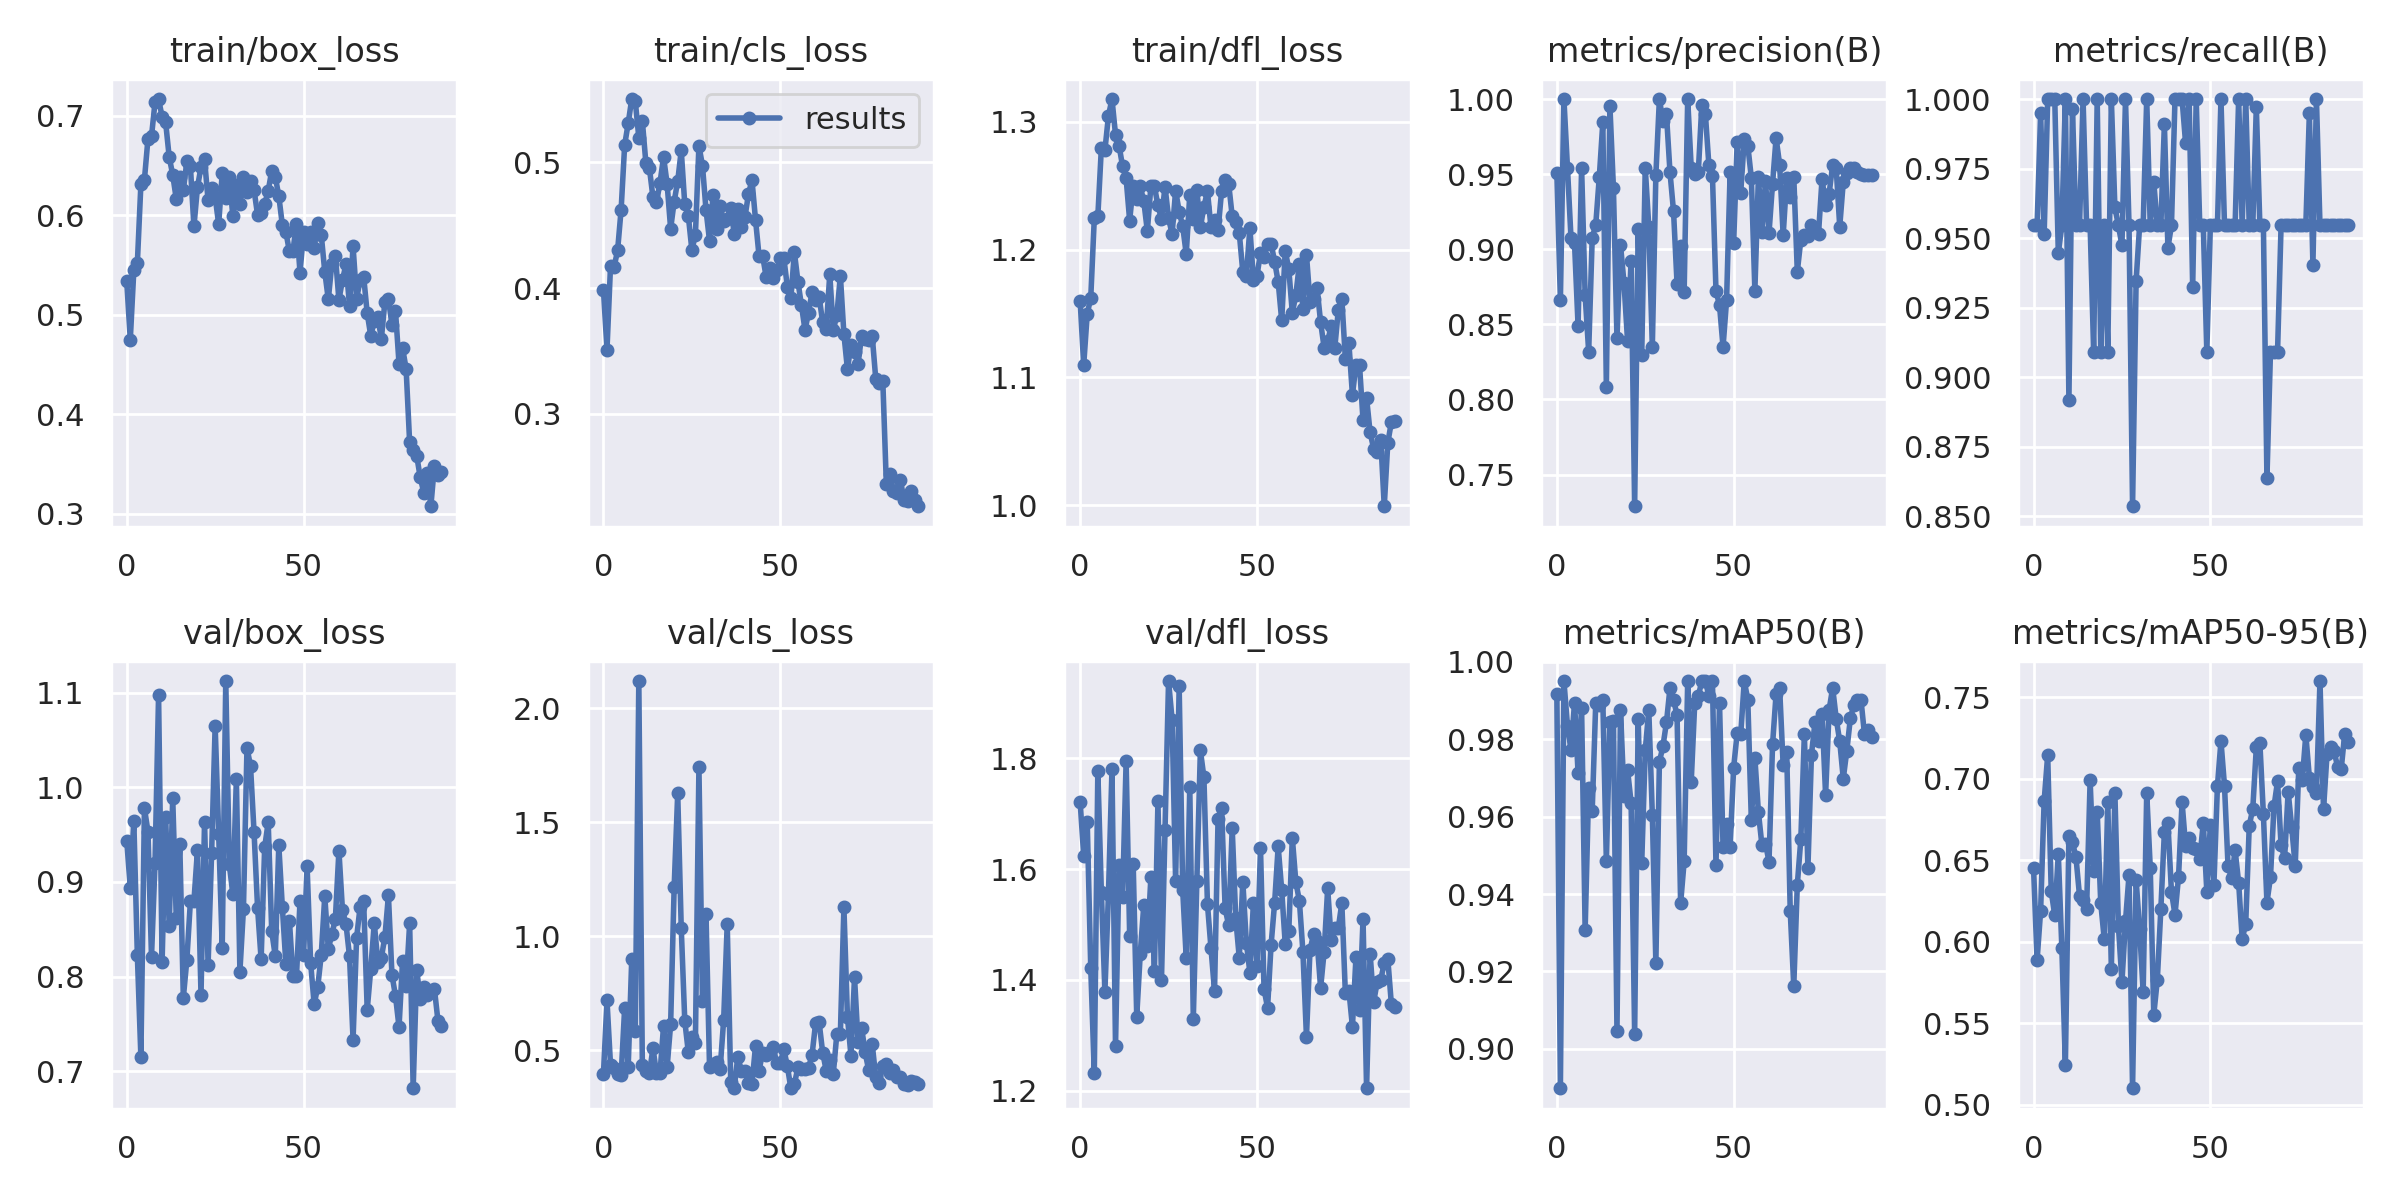

In [39]:
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

Look at one validation batch predictions:

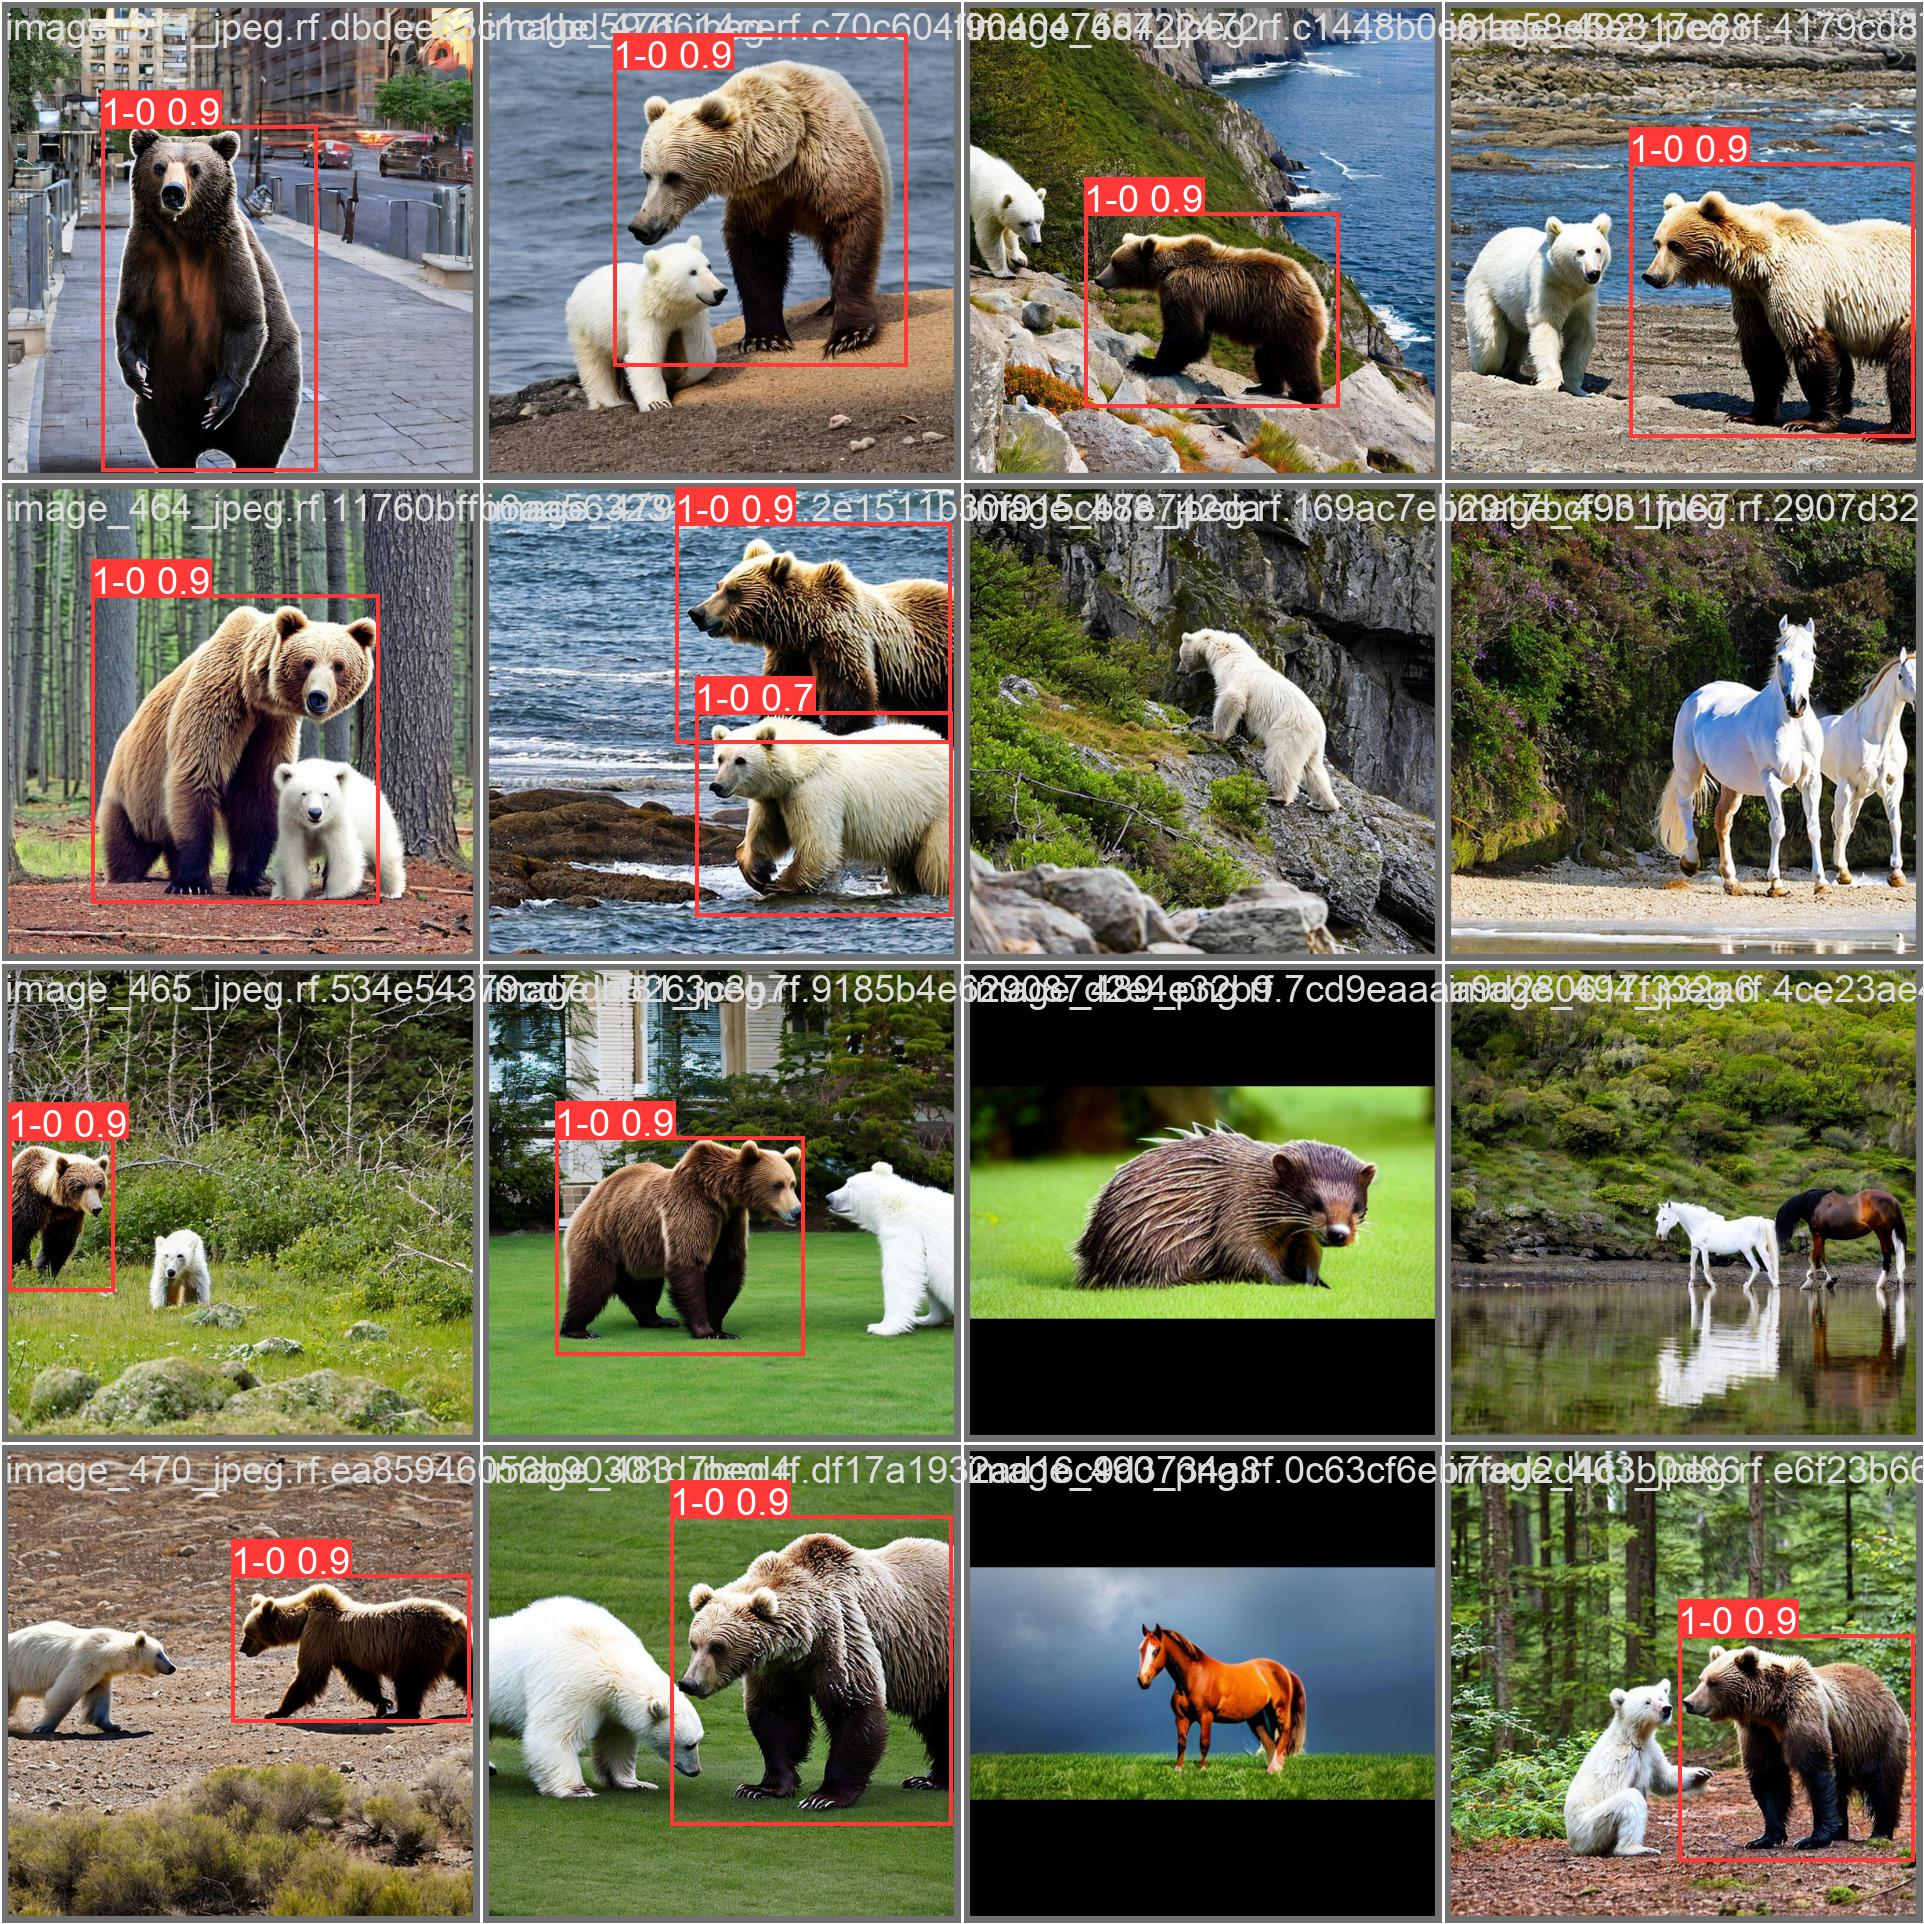

In [44]:
Image(filename=f'{HOME}/runs/detect/train3/val_batch0_pred.jpg', width=600)

Validate the model:

In [46]:
!yolo task=detect mode=val model={HOME}/runs/detect/train3/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/Kaggle-Kontur-8/valid/labels.cache... 68 images, 4
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         68         22      0.945      0.955       0.97       0.76
Speed: 21.3ms preprocess, 18.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val5


# Binary Classifier

The loaded model is ResNet152 fine-tuned to classify images for the presence of brown bears. High recall was a priority during fine-tuning.

In [51]:
resnet = torch.load('/kaggle/input/resnet-finetuned-brownbears-uploaded-30ep/resnet_ft_29ep_upload.pt')
preprocess = ResNet152_Weights.DEFAULT.transforms()

In [52]:
def classify(model, img_dir, file_names, transform, device) -> pd.DataFrame:
    model.eval()

    img_paths = []
    preds = []
    
    for file_name in file_names:
        img_path = os.path.join(img_dir, file_name)
        # read and transform the image
        img = read_image(img_path, mode=ImageReadMode.RGB)
        img = transform(img)
        img = img.unsqueeze(0).to(device)
        # predict
        with torch.no_grad():
            output = model(img)
            pred = output.data.cpu().numpy().argmax()
        # save outputs
        img_paths.append(img_path)
        preds.append(pred)
        
    content = {
        'file_name': file_names,
        'img_path': img_paths,
        'pred': preds,
    }
    return pd.DataFrame(content)

# Inference

## ResNet

Classify the test set images for the presence of brown bears.

In [53]:
img_dir = '/kaggle/input/find-a-bear/bear_images/bear_images'

df_test = pd.read_csv('/kaggle/input/find-a-bear/test.csv')

In [54]:
df_classified_bears  = classify(resnet, img_dir, df_test['file_name'], preprocess, device)
df_classified_bears

,file_name,img_path,pred
0,image_101.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,1
1,image_108.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,1
2,image_109.png,/kaggle/input/find-a-bear/bear_images/bear_ima...,0
3,image_10.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,1
4,image_110.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,1
...,...,...,...
144,image_85.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,0
145,image_91.png,/kaggle/input/find-a-bear/bear_images/bear_ima...,0
146,image_92.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,0
147,image_94.jpeg,/kaggle/input/find-a-bear/bear_images/bear_ima...,0


## YOLOv8

Detect bears on the images that are classified positively by the CNN.

# Predictions after CNN

In [66]:
def generate_submission(model, df_classified: pd.DataFrame, img_dir: str, path: str) -> pd.DataFrame:
    content = {
        'file_name': [],
        'x1': [],
        'y1': [],
        'x2': [],
        'y2': [],
        'confidence': [],
    }

    for _, row in df_classified.iterrows():
        content['file_name'].append(row['file_name'])

        # starting point: no brown bear at the image
        x1_ = y1_ = x2_ = y2_ = conf_ = 0
        
        # if the CNN predicted a brown bear at the image => try to detect
        if row['pred'] == 1:
            # get image path
            img_path = os.path.join(img_dir, row['file_name'])
            img = cv2.imread(img_path)
            
            # detect bears
            detections = model.predict(source=img)

            # pick the most confident detection
            if len(detections) == 1 and len(detections[0].boxes.xyxy.cpu().numpy()) > 0:
                detection = detections[0]
            elif len(detections) > 1:
                confidences = [detection.boxes.conf.cpu().numpy()[0] for detection in detections]
                detection = detections[np.argmax(confidences)]
            # save its bbox coords and confidence
            x1_, y1_, x2_, y2_ = detection.boxes.xyxy.cpu().numpy()[0]
            conf_ = detection.boxes.conf.cpu().numpy()[0]
                
        content['x1'].append(x1_)
        content['y1'].append(y1_)
        content['x2'].append(x2_)
        content['y2'].append(y2_)
        content['confidence'].append(conf_)
        
    # construct and return a dataframe
    df_submission = pd.DataFrame(content)
    df_submission.to_csv(path, index=False)
    
    clear_output()
    
    return df_submission


def generate_predictions(model, img_dir: str, results_path: str):
    """Makes predictions for all the images in `img_dir`.
    Saves the images with the predictions to an archive."""
    model.predict(source=img_dir, save=True)
    clear_output()
    shutil.make_archive(results_path, 'zip', '/kaggle/working/datasets/runs/detect/predict')

In [67]:
model_type = 'best'
yolo = YOLO(f"{HOME}/runs/detect/train3/weights/{model_type}.pt")

submission_path = f'/kaggle/working/submission_{model_type}_augmented.csv'

In [68]:
df_submission = generate_submission(yolo, df_classified_bears, img_dir, submission_path)
df_submission

,file_name,x1,y1,x2,y2,confidence
0,image_101.jpeg,136.774918,291.541565,490.221680,550.074768,0.922349
1,image_108.jpeg,245.254288,525.739990,421.453339,636.010498,0.883342
2,image_109.png,0.000000,0.000000,0.000000,0.000000,0.000000
3,image_10.jpeg,0.000000,0.000000,0.000000,0.000000,0.000000
4,image_110.jpeg,573.984985,270.011932,712.343811,471.757324,0.873339
...,...,...,...,...,...,...
144,image_85.jpeg,0.000000,0.000000,0.000000,0.000000,0.000000
145,image_91.png,0.000000,0.000000,0.000000,0.000000,0.000000
146,image_92.jpeg,0.000000,0.000000,0.000000,0.000000,0.000000
147,image_94.jpeg,0.000000,0.000000,0.000000,0.000000,0.000000
